In [1]:
import numpy as np
from scipy.stats import pearsonr
from scipy.io import loadmat
from nilearn.signal import clean

import NPI

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def flat_without_diagonal(matrix):

    "Flatten the matrix without including the diagonal"
    
    n = matrix.shape[0]
    flattened = []
    for i in range(n):
        for j in list(range(i)) + list(range(i + 1, n)):
            flattened.append(matrix[i][j])
    
    return np.array(flattened)

### **NPI usage demo**

In [ ]:
batch_size              = 50
train_set_proportion    = 0.8
ROI_num                 = 66
using_steps             = 3

In [4]:
signals = np.loadtxt('./WBM_simulation_data/sim_data/dynamics_raw_T_8640_TR_720_seed_000.txt')[2000:]
signals = clean(signals, detrend = True, standardize = 'zscore_sample', low_pass = 0.1, high_pass = 0.01, t_r = 0.72)

real_EC = np.loadtxt('./WBM_simulation_data/sim_data/real_EC_seed_000.txt')
np.fill_diagonal(real_EC, 0)

load_data = loadmat('./WBM_simulation_data/Human_66.mat')
SC = np.array(load_data['C'])
order = np.array(load_data['Order'][0]) - 1
SC = (SC[order].T)[order].T

##### train NN

Several ANNs (MLP, CNN, RNN, VAR) are provided in the NPI framework, which can be used as a surrogate brain.

In [ ]:
inputs, targets = NPI.multi2one(signals, steps = using_steps)

ANN = NPI.ANN_MLP(input_dim = using_steps * ROI_num, hidden_dim = 2 * ROI_num, latent_dim = int(0.8 * ROI_num), output_dim = ROI_num)
# ANN = NPI.ANN_CNN(in_channels = ROI_num, hidden_channels = 3 * ROI_num, out_channels = ROI_num, data_length = using_steps)
# ANN = NPI.ANN_RNN(input_dim = ROI_num, hidden_dim = int(2.5 * ROI_num), latent_dim = int(2.5 * ROI_num), output_dim = ROI_num, data_length = using_steps)
# ANN = NPI.ANN_VAR(input_dim = using_steps * ROI_num, output_dim = ROI_num)

ANN, training_loss, testing_loss = NPI.train_NN(ANN, inputs, targets, batch_size, train_set_proportion, num_epochs = 80, lr = 2e-4, l2 = 5e-5)

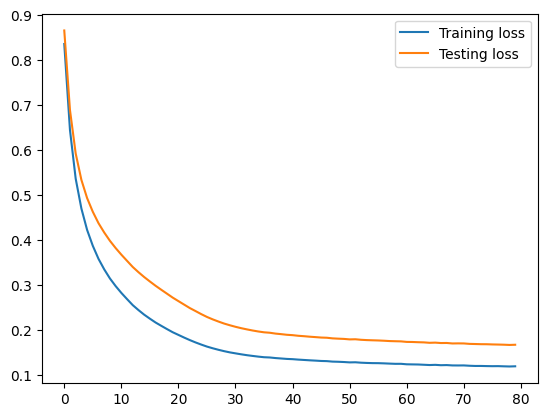

In [6]:
plt.plot(training_loss, label = 'Training loss')
plt.plot(testing_loss, label = 'Testing loss')
plt.legend(loc = 'upper right')
plt.show()

##### calculate empirical FC & model FC

In [7]:
empirical_FC = NPI.corrcoef(signals)
model_FC = NPI.model_FC(ANN, node_num = ROI_num, steps = using_steps)

##### calculate NPI Inferred EC

In [8]:
NPI_EC = NPI.model_EC(ANN, inputs, targets, pert_strength = 1.0)
np.fill_diagonal(NPI_EC, 0)

##### calculate model Jacobian

In [9]:
NPI_Jacobian = NPI.model_Jacobian(ANN, inputs, steps = using_steps)
np.fill_diagonal(NPI_Jacobian, 0)

##### empirical FC - model FC comparison

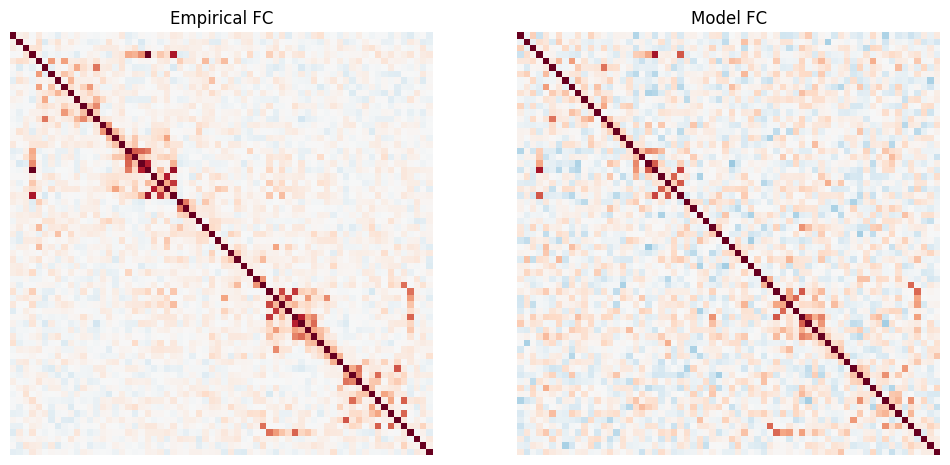

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(empirical_FC, ax = ax1, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(model_FC, ax = ax2, vmin = -1.0, vmax = 1.0, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Empirical FC'); ax2.set_title('Model FC')
plt.show()

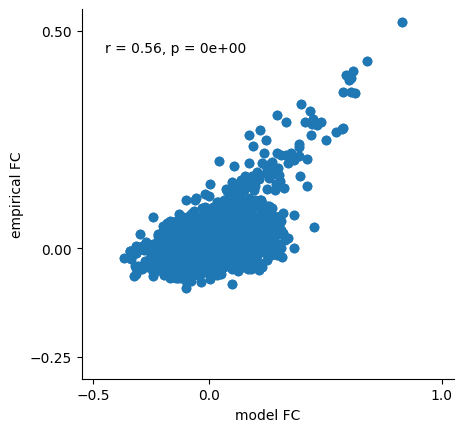

In [11]:
r_value, p_value = pearsonr(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.xlim(-0.55, 1.05); plt.xticks([-0.5, 0.0, 1.0]); plt.xlabel('model FC')
plt.ylim(-0.30, 0.55); plt.yticks([-0.25, 0.0, 0.5]); plt.ylabel('empirical FC')
plt.text(-0.45, 0.45, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### real EC - NPI EC comparison

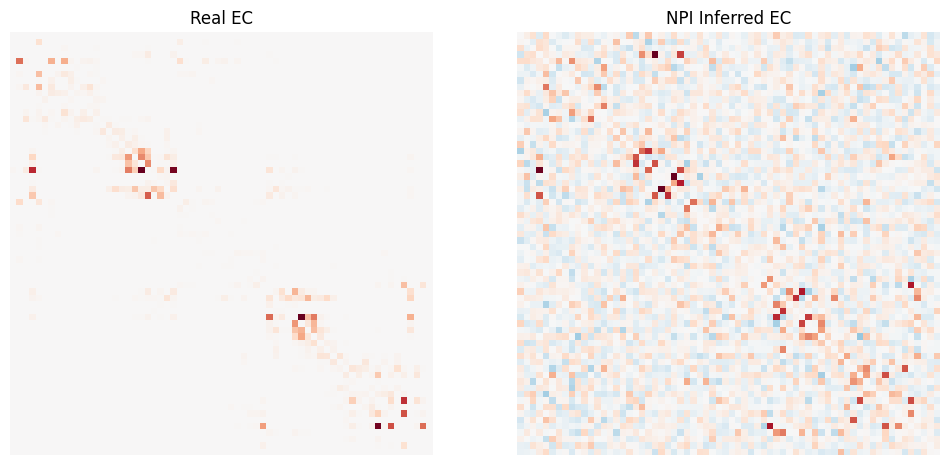

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(real_EC, ax = ax1, vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(NPI_EC, ax = ax2, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Real EC'); ax2.set_title('NPI Inferred EC')
plt.show()

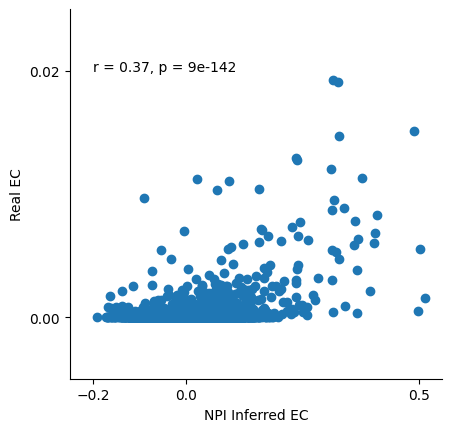

In [13]:
r_value, p_value = pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(real_EC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(NPI_EC), flat_without_diagonal(real_EC))

plt.xlim(-0.25, 0.55); plt.xticks([-0.2, 0.0, 0.5]); plt.xlabel('NPI Inferred EC')
plt.ylim(-0.005, 0.025); plt.yticks([0.0, 0.02]); plt.ylabel('Real EC')
plt.text(-0.2, 0.02, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### real EC - model Jacobian comparison

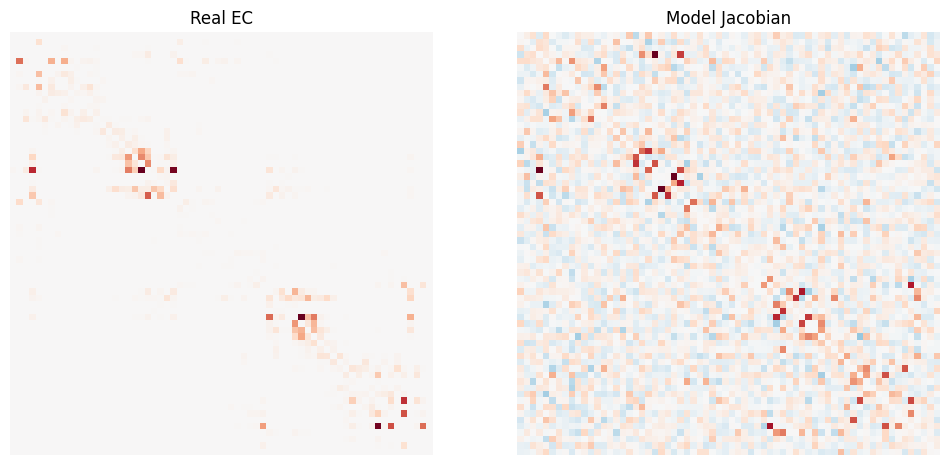

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(real_EC, ax = ax1, vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(NPI_Jacobian, ax = ax2, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Real EC'); ax2.set_title('Model Jacobian')
plt.show()

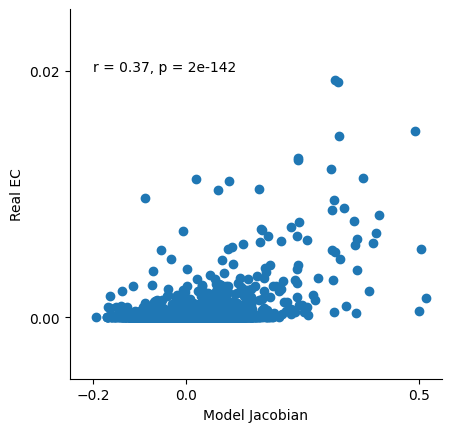

In [15]:
r_value, p_value = pearsonr(flat_without_diagonal(NPI_Jacobian), flat_without_diagonal(real_EC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(NPI_Jacobian), flat_without_diagonal(real_EC))

plt.xlim(-0.25, 0.55); plt.xticks([-0.2, 0.0, 0.5]); plt.xlabel('Model Jacobian')
plt.ylim(-0.005, 0.025); plt.yticks([0.0, 0.02]); plt.ylabel('Real EC')
plt.text(-0.2, 0.02, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### SC - NPI EC comparison

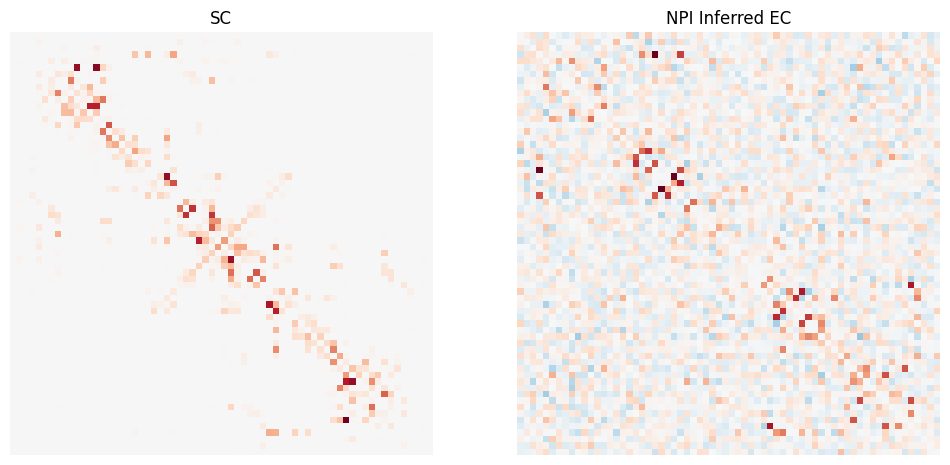

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(SC, ax = ax1, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(NPI_EC, ax = ax2, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('SC'); ax2.set_title('NPI Inferred EC')
plt.show()

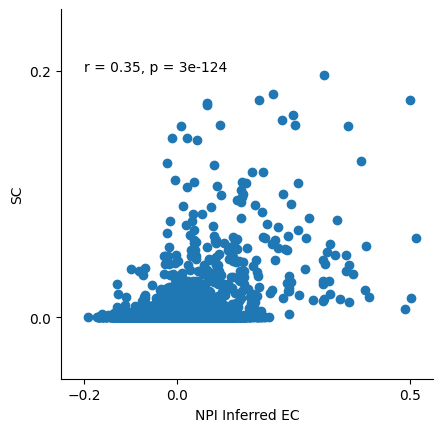

In [17]:
r_value, p_value = pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(SC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(NPI_EC), flat_without_diagonal(SC))

plt.xlim(-0.25, 0.55); plt.xticks([-0.2, 0.0, 0.5]); plt.xlabel('NPI Inferred EC')
plt.ylim(-0.05, 0.25); plt.yticks([0.0, 0.2]); plt.ylabel('SC')
plt.text(-0.2, 0.2, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()